<a href="https://colab.research.google.com/github/sandhrabijoy/Pytorch-and-ML-learning/blob/master/pytorch_practicce3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np, pandas as pd, pylab as pl
import h5py,torch,re
from tensorflow import image as timage
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torch.utils.data.dataset import Subset
import torch.nn as tnn
import torch.utils.checkpoint as tcp
from collections import OrderedDict as od
from IPython.core.magic import register_line_magic
dev= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class TData(tds):
  def __init__(self,X,y):
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.int32)
  def __getitem__(self, index):
    train_img,train_lbl=self.X[index],self.y[index]
    return train_img,train_lbl
  def __len__(self):
    return self.y.shape[0]

In [11]:
def load_h5py(path,img_size):
  f=h5py.File(path,'r')
  keys=list(f.keys());print(keys)
  x=np.array(f[keys[1]],dtype='float32')/255
  x=x.reshape(-1,3,img_size,img_size)
  y=np.array(f[keys[2]],dtype='int32')-1
  N=len(y);n=int(.2*N)
  shuffle_ids=np.arange(N)
  np.random.RandomState(23).shuffle(shuffle_ids)
  x,y=x[shuffle_ids],y[shuffle_ids]
  x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
  y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]

  df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],[x_train.dtype,x_valid.dtype,x_test.dtype],[y_train.shape,y_valid.shape,y_test.shape],[y_train.dtype,y_valid.dtype,y_test.dtype]],
                  columns=['train','valid','test'],index=['image shape','image type','label shape','label type'])
  display(df)
  return[[x_train,x_valid,x_test],[y_train,y_valid,y_test]]


In [12]:
def display_examples(data_loader,img_size):
  for images,labels in data_loader:
    print('Image dimensions:%s'%str(images.shape))
    print('Label dimensions:%s'%str(labels.shape))
    n=np.random.randint(1,50)
    fig=pl.figure(figsize=(11,4))
    for i in range(n,n+5):
      ax=fig.add_subplot(1,5,i-n+1,xticks=[],yticks=[],title=labels[i].item())
      ax.imshow((images[i]).reshape(img_size,img_size,3))
      break
def show_image(img):
  npimg=img.numpy()/2.+.5;tr=(1,2,0)
  pl.figure(figsize=(10,2))
  pl.imshow(np.transpose(npimg,tr))
  pl.xticks([]);pl.show()

def show_examples(data_loader,classes,num_examples):
  dataiter=iter(data_loader)
  images,labels=next(dataiter)
  show_image(utils.make_grid(images[0:num_examples]))
  print('^'.join(('%9s' % classes[labels[j]] for j in range(num_examples))), end='^')

In [13]:
def model_acc(model,data_loader):
  model.eval()
  correct_preds,num_examples=0,0
  for features,targets in data_loader:
    features=features.to(dev)
    targets=targets.to(dev)
    logits,probs=model(features)
    _,pred_labels=torch.max(probs,1)
    num_examples+=targets.size(0)
    correct_preds+=(pred_labels==targets).sum()
  return correct_preds.float()/num_examples*100

@register_line_magic
def print_acc(n):
  if int(n)==1:
    data_loader=[train_loader,valid_loader,test_loader]
  if int(n)==2:
    data_loader=[train_loader2,valid_loader2,test_loader2]
  print('Train accuracy:%.4f%%'%(model_acc(model,data_loader[0])))
  print('Valid acccuracy:%.4f%%'%(model_acc(model,data_loader[1])))
  print('Test acccuracy:%.4f%%'%(model_acc(model,data_loader[2])))

In [14]:
#data
random_seed=12;batch_size=128
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5)
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',transform=transform,download=True,train=True)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False,transform=transform)
train_loader=tdl(dataset=train,shuffle=True,batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True,batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False,batch_size=batch_size)



Files already downloaded and verified


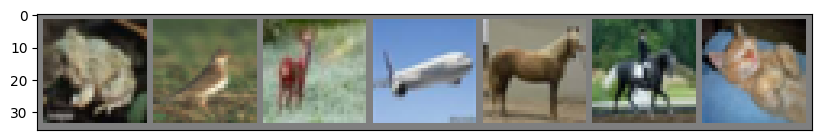

     frog^     bird^     deer^    plane^    horse^    horse^      cat^

In [15]:
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
show_examples(valid_loader,classes,7)

In [18]:
fpath='/content/sample_data/LetterColorImages.h5'

[[x_train,x_valid,x_test], [y_train,y_valid,y_test]]=load_h5py(fpath,32)

['backgrounds', 'images', 'labels']


,train,valid,test
image shape,"(990, 3, 32, 32)","(330, 3, 32, 32)","(330, 3, 32, 32)"
image type,float32,float32,float32
label shape,"(990,)","(330,)","(330,)"
label type,int32,int32,int32
